In [1]:
from astropy.io import fits
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.wcs import WCS
import cv2
import scipy.ndimage
from glob import glob
from astropy.convolution import convolve_fft
from IPython.display import Audio, display, HTML, Video, Markdown
import matplotlib.animation as animation

In [2]:
# Coordinate Transforms
def to_world(fname,pix_x,pix_y):
    return WCS(fname).all_pix2world(pix_x,pix_y,0)
def to_pix(fname,ra,dec):
    return WCS(fname).all_world2pix(ra,dec,0)

# Kernel Adjustments
def check_kernel(kernel_fname):
    if type(kernel_fname) is str:
        kernel = fits.open(kernel_fname)[0].data
    else:
        kernel = kernel_fname
    # Square
    if kernel.shape[0] != kernel.shape[1]:
        print("Additional Code Required. Square the Kernel.")
    # Max in Center
    ind = np.unravel_index(np.argmax(kernel),np.shape(kernel))    
    if ind[0] != ind[1] and np.abs(ind[0] / kernel.shape[0] - 0.5) > 0.002:
        print("Additional Code Required. Max value not centered.")
        print(np.abs(ind[0] / kernel.shape[0] - 0.5))
    # Normalize
    if np.nansum(kernel) != 1:
        kernel = kernel / np.nansum(kernel) 
    return kernel

# Reduce Mask 
def mask_reduction(x,y):
    # Create mask arrays. 
    maskx_x, maskx_y = [],[]
    for i in range(np.max(x)): 
        # remove duplicates in X          
        look = np.where(x == i)[0]
        dim = np.shape(look)
        if dim[0] > 0: 
             maskx_y.append(y[look[0]])
             maskx_y.append(y[look[len(look)-1]])
             maskx_x.append(x[look[0]])
             maskx_x.append(x[look[len(look)-1]])

    masky_x, masky_y = [],[]
    for i in range(np.max(y)):  
        # remove duplicates in Y
        look = np.where(y == i)[0]
        dim = np.shape(look)
        if dim[0] > 0: 
             masky_y.append(y[look[0]])
             masky_y.append(y[look[len(look)-1]])
             masky_x.append(x[look[0]])
             masky_x.append(x[look[len(look)-1]])

    mask_x = maskx_x + masky_x         
    mask_y = maskx_y + masky_y

    return np.asarray(list(zip(mask_x,mask_y)))

# Diffusion
def ApplyBoundaryConditions(original_data, new_data, index_set, timestep) :
    for indexPair in index_set :
        # Converts between index in original image and index in smaller template img. 
        # Diffusion occurs in smaller template image and then gets replaced in the 
        i = int(indexPair[1]) - minY
        j = int(indexPair[0]) - minX
        new_data[i,j,timestep] = original_data[int(indexPair[1]), int(indexPair[0])]
def StepForward(data, timestep) :
    xLim, yLim, junk = np.shape(data)
    # Kappa should be small to avoid converging too quicly, 
    # but is arbitrary as we are using the 
    # homoginzed solution as a final stopping place. 
    alpha = 0.1
    for i in range(1, xLim-1) :
        for j in range(1, yLim-1) :
            # Discretizing heat equation
            # Backward Finite Difference in Time
            # Second Order Central Difference in Space
            data[i,j,timestep] = data[i,j,timestep-1] + alpha * (
                    (data[i+1,j,timestep-1] - 2*data[i,j,timestep-1] +
                    data[i-1,j,timestep-1]) + (data[i,j+1,timestep-1] -
                        2*data[i,j,timestep-1] + data[i,j-1,timestep-1]
                            ))        
def InsideSet(index_array, i, j) :
    sameJ = np.where(np.isclose(index_array[:, 1], j))[0]
    sameI = np.where(np.isclose(index_array[:, 0], i))[0]
    if len(sameJ) == 0 or len(sameI) == 0 :
        return False
    possibleIs = index_array[sameJ][:,0]
    possibleJs = index_array[sameI][:,1]
    minI = min(possibleIs)
    minJ = min(possibleJs)
    maxI = max(possibleIs)
    maxJ = max(possibleJs)
    if minI <= i and i <= maxI and minJ <= j and j <= maxJ :
        return True
    return False

def extend_mask(extend,edge_x,edge_y,mask_x,mask_y):
    mid_x = (np.max(edge_x)+np.min(edge_x))/2; mid_y = (np.max(edge_y)+np.min(edge_y))/2
    mask_x = np.asarray(mask_x);     mask_y = np.asarray(mask_y)
    push_x = np.copy(mask_x);        push_y = np.copy(mask_y)

    
    for i in range(len(mask_x)): 
        if mask_x[i] < mid_x:
            push_x[i] = mask_x[i] - extend
        if mask_x[i] > mid_x:
            push_x[i] = mask_x[i] + extend
        if mask_y[i] > mid_y:
            push_y[i] = mask_y[i] + extend
        if mask_y[i] < mid_y:
            push_y[i] = mask_y[i] - extend

    # ----> Top and Bottom 
    fpx = mid_x - 1 - extend
    lpx = mid_x + 1 + extend 
    fpy = np.max(mask_y) + extend
    fppy = np.min(mask_y) - extend
    fyrr = np.repeat(fpy,lpx-fpx)
    fypr = np.repeat(fppy,lpx-fpx)           
    fxrr = np.arange(fpx,lpx)
    push_x = np.append(push_x,fxrr)
    push_y = np.append(push_y,fyrr)
    push_x = np.append(push_x,fxrr)
    push_y = np.append(push_y,fypr)
    # -----> Left and Right
    kpx = np.max(mask_x) + extend 
    kppx = np.min(mask_x) - extend
    kpy = mid_y - 1 - extend
    kppy = mid_y + 1 + extend 
    kxrr = np.repeat(kpx,kppy - kpy)
    kxpr = np.repeat(kppx,kppy - kpy)
    kyrr = np.arange(kpy,kppy)
    push_x = np.append(push_x,kxrr)
    push_y = np.append(push_y,kyrr)
    push_x = np.append(push_x,kxpr)
    push_y = np.append(push_y,kyrr)

    return push_x,push_y

kernel_file = glob("Convolve_Regrid/Kernels/*.fits") 

## Spitzer and Herschel Infrared Images at 24, 70, 100 and 160 microns.

In [3]:
infrared_file = ["Original_Files/Infrared/" + file for file in ["n76crop_smcsage_24.fits","e0102_pacs70_new.fits","e0102_pacs100_new.fits","e0102_pacs160_new.fits"]]

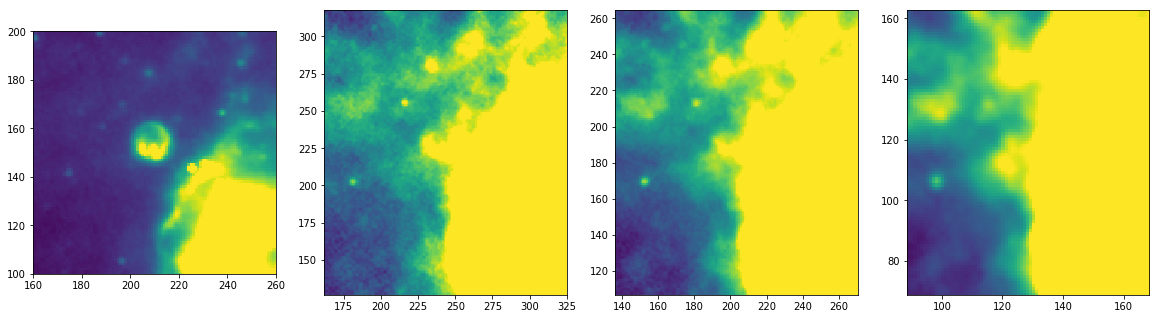

In [4]:
# Set plot dimensions by first image and transform coordinates to the other images
xdim = [160,260]
ydim = [100,200]
ra,dec = to_world(infrared_file[0],xdim,ydim)
dim = np.array([to_pix(file,ra,dec) for file in infrared_file])

# Get a region to sample the min,max of the image.
d = [fits.open(file)[0].data[int(dim[i,0,0]):int(dim[i,0,1]),int(dim[i,1,0]):int(dim[i,1,1])] for i,file in enumerate(infrared_file)]

f, axes = plt.subplots(1,4,figsize=(20,10))
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].set_xlim(to_pix(file,ra,dec)[0]) for i,file in enumerate(infrared_file)]
[axes[i].set_ylim(to_pix(file,ra,dec)[1]) for i,file in enumerate(infrared_file)];

## Create Mask from Convolved Xray File

In [5]:
xray_file = 'Original_Files/Xray/e0102_1100-2000eV.fits'
xray_kernel_files = [kernel_file[i] for i in [1,4,2,3]]
xray_kernels = [check_kernel(kernel) for kernel in xray_kernel_files]

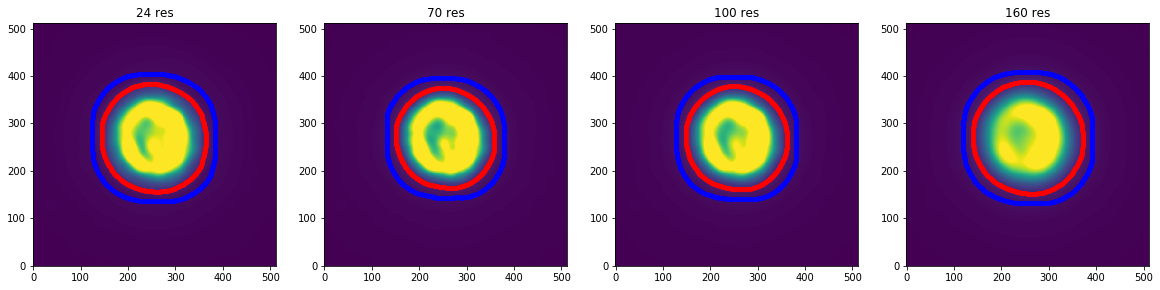

In [24]:
# Middle two rows should be zero or there may be some rotation. 
xray_kernel_scales = np.array([fits.open(file)[0].header[key] for file in xray_kernel_files for key in  ['CD1_1','CD1_2','CD2_1','CD2_2'] ])

# The absolute value of CDELT1 and CDELT2 should be equal. 
xray_image_scale = np.abs(fits.open(xray_file)[0].header['CDELT1'])

# Scaling is xray image / kernel
xray_scale = xray_image_scale / xray_kernel_scales[0]

# Invert scaling to regrid
new_kernels = [check_kernel(scipy.ndimage.zoom(kernel, 1/xray_scale, order = 1)) for kernel in xray_kernels]

# Convolve
convolved_xray = [convolve_fft(fits.open(xray_file)[0].data,kernel,allow_huge=True) for kernel in new_kernels ]

# Detect Edges 
edges = [cv2.Canny(np.uint8(convolution),0,5) for convolution in convolved_xray]

# Get Edge Coordinates
ys,xs = [np.array(np.where(edge == 255) )[0] for edge in edges], [np.array(np.where(edge == 255) )[1] for edge in edges]

# Reduce Coordinates
masks = [mask_reduction(x,y) for x,y in zip(xs,ys)]

# Push Mask Out 
extend = 20
extend_masks = [extend_mask(extend,xs[i],ys[i],np.copy(masks[i][:,0]),np.copy(masks[i][:,1])) for i in range(4)]


# Convolved Xray Image with Mask
f, axes = plt.subplots(1,4,figsize=(20,10))
[axes[i].imshow(file, origin='lower',vmin=0,vmax=10) for i,file in enumerate(convolved_xray)]
[axes[i].set_title(title) for i,title in enumerate(['24 res','70 res','100 res','160 res'])];
[axes[i].scatter(masks[i][:,0],masks[i][:,1],c='r',s=10) for i in range(4)];
[axes[i].scatter(np.array(extend_masks[i])[0,:],np.array(extend_masks[i])[1,:],c='b',s=10) for i in range(4)];

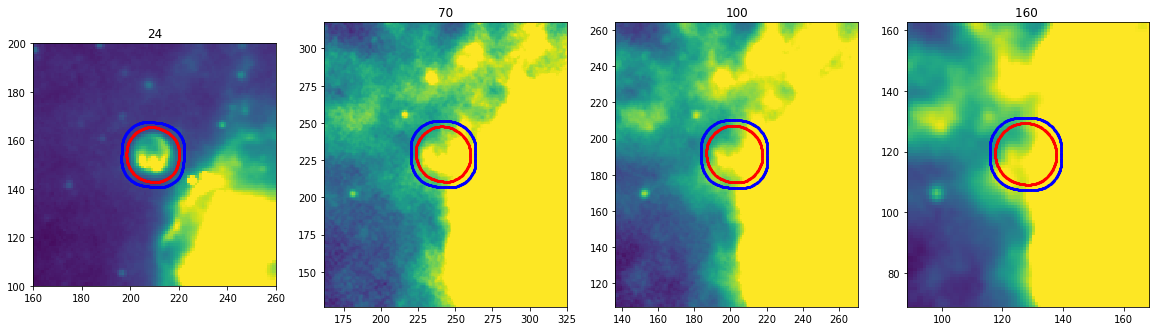

In [26]:
# Transform Mask Coordinates to Appropriate Infrared Image
mask_wcs = [to_world(xray_file,masks[i][:,0],masks[i][:,1]) for i in range(4)]
mask_pix = np.array([to_pix(infrared_file[i],np.array(mask_wcs[i])[0,:],np.array(mask_wcs[i])[1,:]) for i in range(4)])

extend_mask_wcs = [to_world(xray_file,np.array(extend_masks[i])[0,:],np.array(extend_masks[i])[1,:]) for i in range(4)]
extend_mask_pix = np.array([to_pix(infrared_file[i],np.array(extend_mask_wcs[i])[0,:],np.array(extend_mask_wcs[i])[1,:]) for i in range(4)])

# Infrared Mask Coordinates
f, axes = plt.subplots(1,4,figsize=(20,10))
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].set_xlim(to_pix(file,ra,dec)[0]) for i,file in enumerate(infrared_file)]
[axes[i].set_ylim(to_pix(file,ra,dec)[1]) for i,file in enumerate(infrared_file)];
[axes[i].scatter(mask_pix[i][0],mask_pix[i][1],c="r",s=1) for i in range(4)];
[axes[i].scatter(extend_mask_pix[i][0],extend_mask_pix[i][1],c="b",s=1) for i in range(4)];
[axes[i].set_title(title) for i,title in enumerate(['24','70','100','160 '])];

## Background Removal

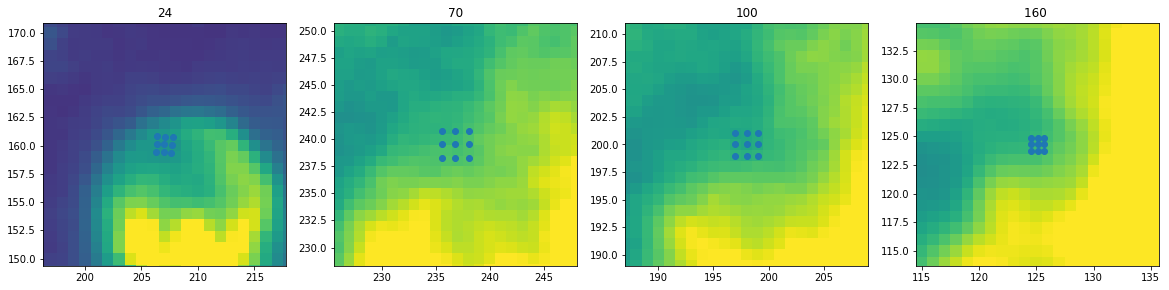

In [27]:
# We know this region is easily oversubtracted. It's the lowest point in the supernova. 
# The background removal shouldn't make this region negative if it's done right. 
null_ra,null_dec = np.loadtxt("Background_Removal/Bootstrap/NullRegionCoordinates.txt")
null_coords =  np.array([to_pix(infrared_file[i],null_ra,null_dec) for i in range(4)])

# Low Emission Region
f, axes = plt.subplots(1,4,figsize=(20,10))
n=10
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].set_xlim(np.min(null_coords[i][0,:])-n,np.max(null_coords[i][0,:])+n) for i in range(4)]
[axes[i].set_ylim(np.min(null_coords[i][1,:])-n,np.max(null_coords[i][1,:])+n) for i in range(4)]
[axes[i].scatter(null_coords[i][0,:],null_coords[i][1,:]) for i in range(4)];
[axes[i].set_title(title) for i,title in enumerate(['24','70','100','160 '])];

In [28]:
def diffusion_inpainting(x,y,data):
    x = x.astype(int)
    y = y.astype(int)
    
    global minY, minX
        
    minX = int(min(x))
    maxX = int(max(x)+1)
    minY = int(min(y))
    maxY = int(max(y)+1)
        
    xyZip = list(zip(x,y))
    xyArray = np.asarray(xyZip)

    saveEveryXFrames = 5
    maxNumberOfSteps = 10000

    saveCounter = 0
    intensity_values = np.zeros([maxY-minY, maxX-minX, maxNumberOfSteps])
    # Fill in the mask coordinates with their original intensity values. 
    ApplyBoundaryConditions(data, intensity_values, xyZip, 0);
    
    count = maxNumberOfSteps / 10
    
    insideIndices = []
    shell = np.copy(data)
    for i in range(shell.shape[0]):
        for j in range(shell.shape[1]):
            if InsideSet(xyArray, i, j) :
                insideIndices.append((i, j))
                    
    subs, shells = [],[]
    for t in range(1,maxNumberOfSteps):
        # Do Diffusion Step
        StepForward(intensity_values, t);
        # Re-plug in the mask intensitity values.
        ApplyBoundaryConditions(data, intensity_values, xyZip, t);
        
        if t % count == 0 :
            print("Current iteration = " + str(t))
        
        for idx in range(len(insideIndices)):
            i = insideIndices[idx][0]
            j = insideIndices[idx][1]
            shell[j,i] = intensity_values[j-minY, i-minX, t]

        # Remove the background (shell) from the original image.
        shells.append(np.copy(shell))
        subs.append(np.copy(data) - np.copy(shell))
        
    
    return subs, shells

sub, shell = diffusion_inpainting(extend_mask_pix[0][0],extend_mask_pix[0][1],fits.open(infrared_file[0])[0].data)

Current iteration = 1000
Current iteration = 2000
Current iteration = 3000
Current iteration = 4000
Current iteration = 5000
Current iteration = 6000
Current iteration = 7000
Current iteration = 8000
Current iteration = 9000


In [50]:
animation_name = "Diffuse24"
# Set up the animation
vmin,vmax = 0, 5

f, axes = plt.subplots(1,2,figsize=(20,8))
im_snr = axes[0].imshow(sub[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
im_bkgd = axes[1].imshow(shell[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
[ax.set_xlim(180,240) for ax in axes]
[ax.set_ylim(120,180) for ax in axes]

def run(i):
    im_snr.set_array(sub[i])
    im_bkgd.set_array(shell[i])
    
    return im_snr, im_bkgd
    

plt.tight_layout()
plt.close()

# Write the animation out 
ani = animation.FuncAnimation(f, run,np.arange(0,3000,5), blit=False, interval=200, repeat=True)
#ani.save('%s.gif' % gifname,writer='imagemagick')

ani.save('%s.mp4' % animation_name,writer='ffmpeg')


In [23]:
Video("Diffuse24.mp4")

[(120, 180), (120, 180)]

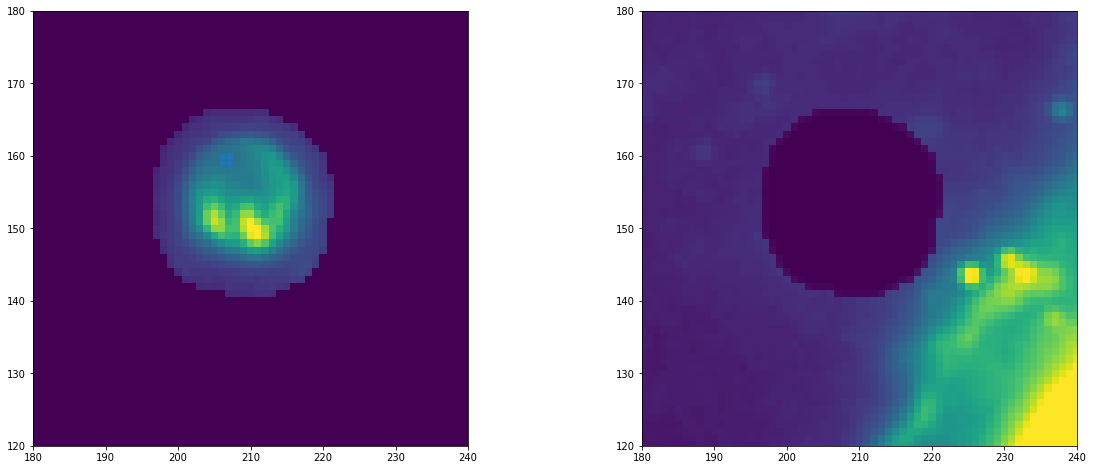

In [43]:
f, axes = plt.subplots(1,2,figsize=(20,8))
im_snr = axes[0].imshow(sub[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
im_bkgd = axes[1].imshow(shell[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
axes[0].scatter(null_coords[0][0,:].astype(int),null_coords[0][1,:].astype(int))
[ax.set_xlim(180,240) for ax in axes]
[ax.set_ylim(120,180) for ax in axes]


In [47]:
sum_n = [np.sum(np.array(s)[null_coords[0][1,:].astype(int),null_coords[0][0,:].astype(int)]) for s in sub]
plt.plot(sum_n)